##**Clasificación de imágenes de insectos**


tres modelos que clasifican cuatro clases de imágenes: abejas, avispas, otros insectos y otros (animales, comida, personas)

Tres modelos: 

Secuencial con data augmentation, dropout y regularización

VGG19 con Imagenet

ResNet50 con Imagenet

In [ ]:
%%bash
mkdir ~/.kaggle
mv kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
cat ~/.kaggle/kaggle.json #credenciales de kaggle generadas con la API

{"username":"kristinp9","key":"2b9a20aef527a95c59db004baa4642f5"}

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d jerzydziewierz/bee-vs-wasp

bee-vs-wasp.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip bee-vs-wasp.zip 

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: kaggle_bee_vs_wasp/other_noinsect/576513.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/576622.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/576810.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/576855.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/576993.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577087.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577126.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577128.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577283.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577310.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577643.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577807.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577847.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/578261.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/578295.jpg  
  inflating: kaggle_bee_vs_wasp/other_n

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

In [ ]:
labels = pd.read_csv("kaggle_bee_vs_wasp/labels.csv", dtype=str)
labels
#el dataset con los paths y las etiquetas de cada clase

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee
...,...,...,...,...,...,...,...,...,...,...
11416,11417,other_noinsect\581704.jpg,0,0,0,1,0,0,1,other
11417,11418,other_noinsect\581873.jpg,0,0,0,1,0,0,1,other
11418,11419,other_noinsect\581880.jpg,0,0,0,1,0,1,0,other
11419,11420,other_noinsect\6778651038_294d392627_n.jpg,0,0,0,1,0,0,1,other


In [ ]:
duplicados = labels[labels.duplicated()]
print(duplicados) #Chequeamos no tener valores duplicados. No tenemos

Empty DataFrame
Columns: [id, path, is_bee, is_wasp, is_otherinsect, is_other, photo_quality, is_validation, is_final_validation, label]
Index: []


In [ ]:
import os
labels.path = labels["path"].str.replace("\\","/")
labels.describe()
#reemplazamos la doble barra en el nombre de archivos del dataset de etiquetas porque genera problemas para que flow from dataframe detecte el path

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
count,11421,11421,11421,11421,11421,11421,11421,11421,11421,11421
unique,11421,11421,2,2,2,2,2,2,2,4
top,4966,wasp2/I00366.jpg,0,0,0,0,1,0,0,wasp
freq,1,1,8238,6478,8982,10565,7035,9702,9658,4943


In [ ]:
labels.shape #contamos con 11421 datos

(11421, 10)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Seccion')

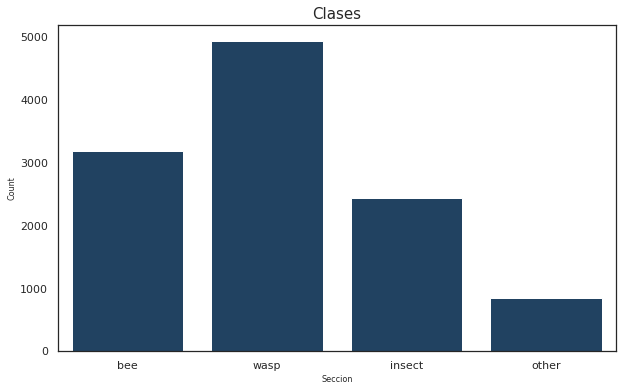

In [ ]:
#visualizamos qué cantidad tenemos de cada clase
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.set(style='white',context='notebook')
sns.countplot(labels['label'],color=(0.09, 0.26, 0.42, 0));
plt.title('clases'.title(),fontsize=15);
plt.ylabel('count'.title(), fontsize=8)
plt.xlabel('seccion'.title(), fontsize=8)

In [ ]:
labels['label'].value_counts(1)

wasp      0.432799
bee       0.278697
insect    0.213554
other     0.074950
Name: label, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

X=labels.drop(columns=['label','id'])
y=labels["label"]

train, val = train_test_split(labels, test_size=.2, random_state=42)
val, test = train_test_split(val, test_size=.5, random_state=42)
print('train:', train.shape, '\nval:', val.shape, '\ntest',  test.shape)

train: (9136, 10) 
val: (1142, 10) 
test (1143, 10)


## Modelo secuencial con data augmentation, regularización y dropout

In [ ]:
#chequeamos valores que tenemos en train
labels["label"].value_counts()

wasp      4943
bee       3183
insect    2439
other      856
Name: label, dtype: int64

In [ ]:
#generador de imagenes nuevas
directory_path=None
batch_size=64
generador_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = generador_train.flow_from_dataframe(
            train,
            directory="kaggle_bee_vs_wasp/",
            x_col="path",
            y_col="label",
            has_ext=False,
            subset="training",
            batch_size=64,
            seed=42,
            clases=None,
            shuffle=True,
            class_mode="categorical",
            target_size=(150, 150),
            color_mode="rgb")

validation_generator = val_datagen.flow_from_dataframe(
            val,
            directory="kaggle_bee_vs_wasp/",
            x_col="path",
            y_col="label",
            has_ext=False,
            batch_size=64,
            seed=42,
            classes=None,
            shuffle=False,
            class_mode="categorical",
            target_size=(150, 150),
            color_mode="rgb") 

test_datagen=ImageDataGenerator(rescale=1./255.)
test_g = test_datagen.flow_from_dataframe(test,
            directory="kaggle_bee_vs_wasp/",
            x_col="path",
            y_col='label',
            has_ext=False,
            target_size=(150, 150),
            class_mode="categorical",
            classes=None,
            batch_size=64,
            color_mode="rgb",
            seed=42,)

Found 9136 validated image filenames belonging to 4 classes.
Found 1142 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


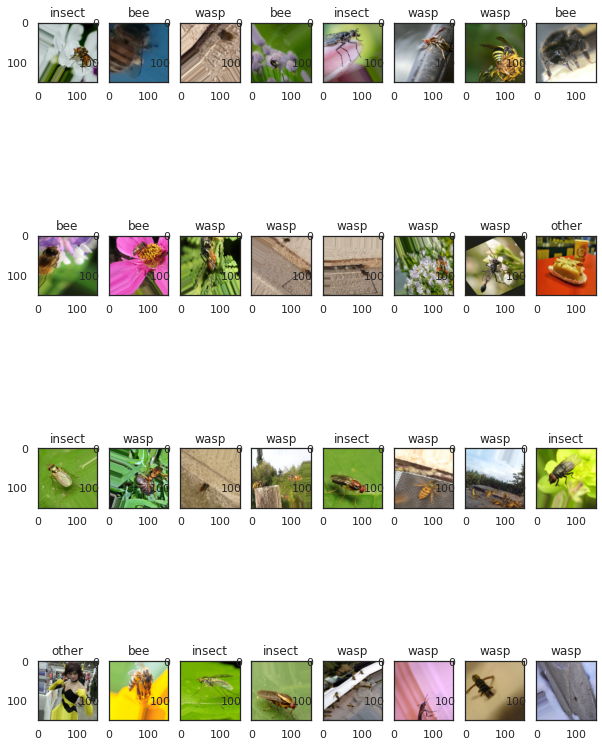

In [ ]:
classes = list(train_generator.class_indices.keys())
classes
w = 10
h = 10
fig = plt.figure(figsize=(10, 15))
columns = 8
rows = 4
ax = []
x,y = train_generator.next()
for i in range(columns*rows):
    image = x[i]
    label = classes[list(y[i]).index(1)]
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(label)
    plt.imshow(image)
plt.show()

In [ ]:
classes

['bee', 'insect', 'other', 'wasp']

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from google.colab import files
from keras.models import load_model
checkpoint_model3 = ModelCheckpoint('from_scratch/weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_accuracy', verbose=0,
                             save_best_only=False, save_weights_only=False, mode='auto')

#files.download('model3.h5')

reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1)
early_stopping=EarlyStopping(monitor='val_loss',min_delta=0.001,patience=4,restore_best_weights=True,verbose=1)

callbacks=[reduce_lr, early_stopping, checkpoint_model3]


In [ ]:
#Probamos una red con data augmentation + regularización y dropout en la última capa
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dropout_rate=0.3
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
model3.add(Dropout(dropout_rate))
model3.add(layers.Dense(4, activation='softmax'))


In [ ]:
model3.summary()
model3.save('model3.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Antes de fitear vamos a equilibrar las clases 
from sklearn import preprocessing
lb_classes = preprocessing.LabelBinarizer()

# Ajustamos a la variable labels
lb_classes.fit(labels['label'])
lb_classes.classes_

array(['bee', 'insect', 'other', 'wasp'], dtype='<U6')

In [ ]:
# Encodeamos las labels
labels_ohe = pd.DataFrame(lb_classes.transform(labels['label']), columns=lb_classes.classes_, index=labels['id'])
labels_ohe.head()

,bee,insect,other,wasp
id,,,,
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0


In [ ]:
class_weight = {k:v for k,v in zip(range(len(lb_classes.classes_)),
                                   (1/labels_ohe.iloc[train.index].sum()) * 100)}

class_weight

{0: 0.0395882818685669,
 1: 0.051493305870236865,
 2: 0.14326647564469913,
 3: 0.025188916876574305}

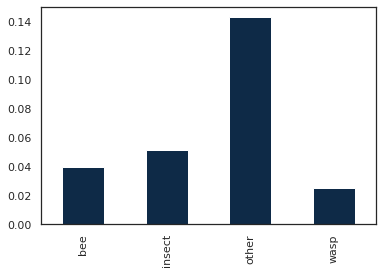

In [ ]:
# Visualizamos los pesos definidos
((1/labels_ohe.iloc[train.index].sum()) * 100).plot(kind='bar', color=["#0e2a47"]);

In [ ]:
history3 = model3.fit(
      train_generator,
      steps_per_epoch=train_generator.n//train_generator.batch_size, #train / batch size. 
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.n//validation_generator.batch_size,
      class_weight=class_weight,
      callbacks=callbacks)
#fiteamos el modelo con data augmentation

Epoch 1/20
142/142 [==============================] - 72s 507ms/step - loss: 4.5411 - accuracy: 0.2910 - val_loss: 1.7372 - val_accuracy: 0.3235
Epoch 2/20
142/142 [==============================] - 72s 508ms/step - loss: 0.4541 - accuracy: 0.4776 - val_loss: 1.7514 - val_accuracy: 0.4200
Epoch 3/20
142/142 [==============================] - 72s 507ms/step - loss: 0.4386 - accuracy: 0.5582 - val_loss: 1.5329 - val_accuracy: 0.5395
Epoch 4/20
142/142 [==============================] - 73s 515ms/step - loss: 0.4339 - accuracy: 0.5732 - val_loss: 1.5319 - val_accuracy: 0.4926
Epoch 5/20
142/142 [==============================] - 74s 524ms/step - loss: 0.4285 - accuracy: 0.6003 - val_loss: 1.5135 - val_accuracy: 0.5349
Epoch 6/20
142/142 [==============================] - 74s 523ms/step - loss: 0.4259 - accuracy: 0.6031 - val_loss: 1.5064 - val_accuracy: 0.5358
Epoch 7/20
142/142 [==============================] - 74s 521ms/step - loss: 0.4239 - accuracy: 0.6145 - val_loss: 1.3991 - val_ac

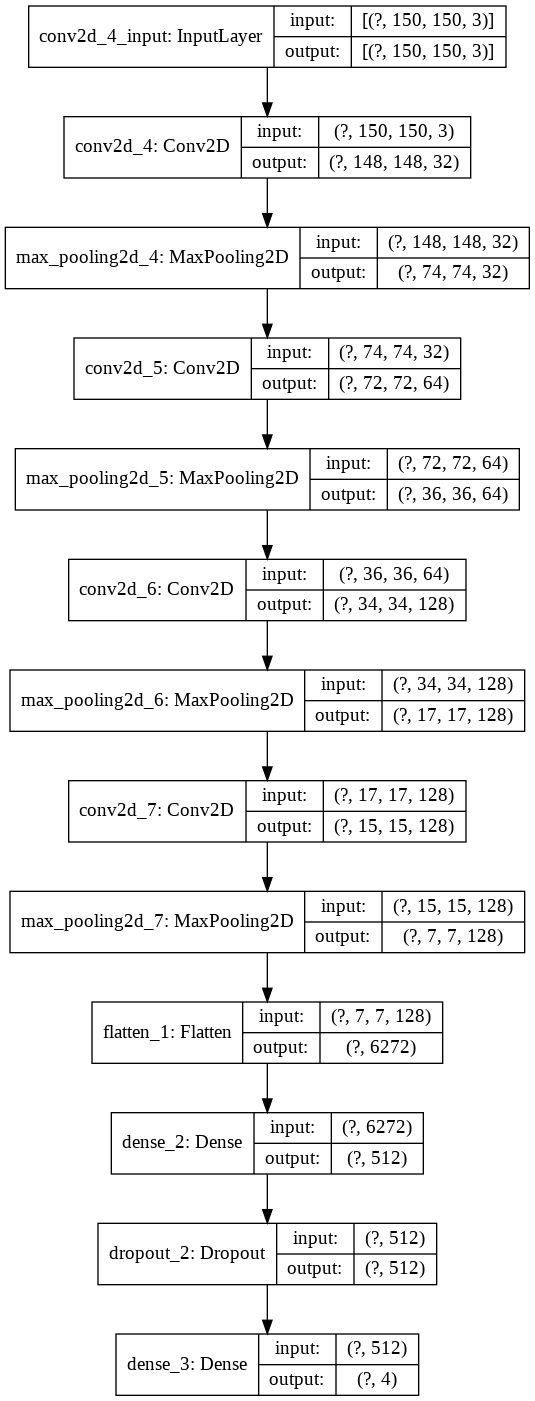

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model3, show_shapes=True)

In [ ]:
from keras.models import load_model
model3.save('model3.h5')
#model3 = load_model('model3.h5')

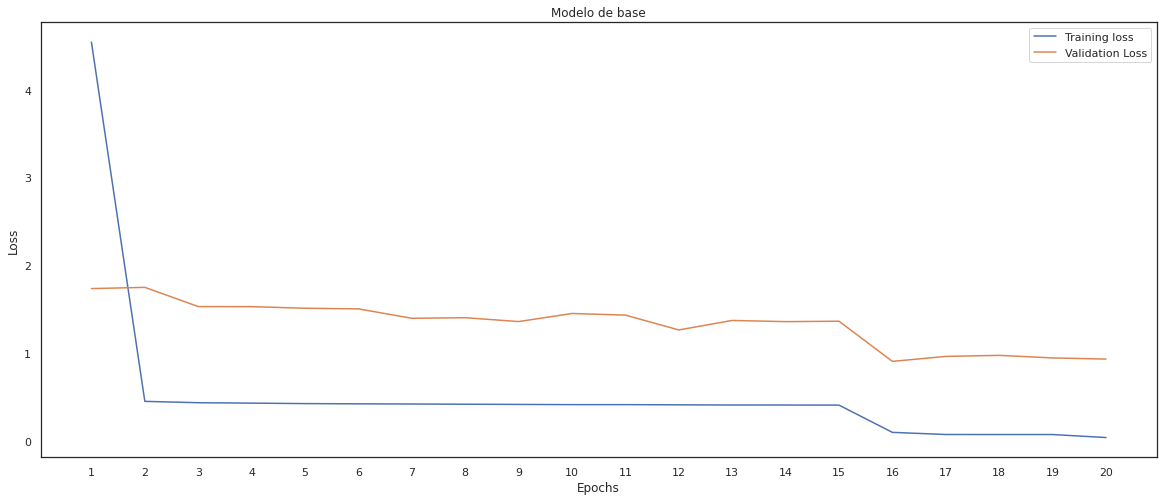

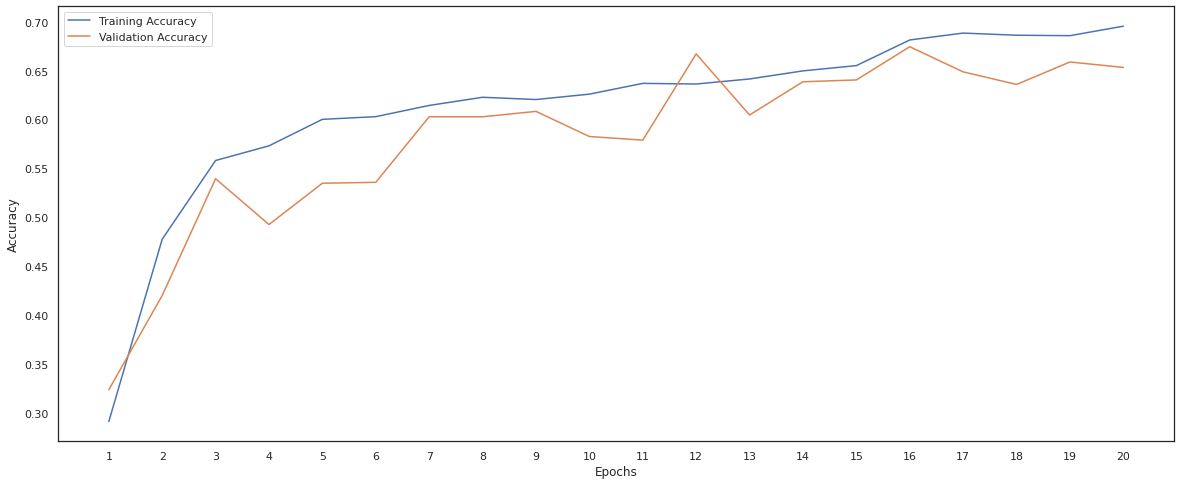

In [ ]:
acc3=history3.history['accuracy']
val_loss3=history3.history['val_loss']
loss3=history3.history['loss']
val_acc3=history3.history['val_accuracy']
epochs3 = range(1, len(acc3) + 1)

plt.figure(figsize=(20,8))
plt.title('Modelo de base')
plt.plot(epochs3,loss3)
plt.plot(epochs3,val_loss3)
plt.xticks(ticks=epochs3)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss','Validation Loss'])

plt.figure(figsize=(20,8))
plt.plot(epochs3,acc3)
plt.plot(epochs3,val_acc3)
plt.xticks(ticks=epochs3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy']);

In [ ]:
model3.evaluate(test_g)

18/18 [==============================] - 4s 200ms/step - loss: 0.8748 - accuracy: 0.6982


[0.8747649788856506, 0.6981627345085144]

##VGG19

In [ ]:
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
#Creamos train y test para vgg19 con el preprocesamiento que ya existe
from tensorflow.keras.applications.vgg19 import preprocess_input

train_datagen_vgg = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True
)

val_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20

       # Train 
train_vgg = train_datagen_vgg.flow_from_dataframe(train,
            directory="kaggle_bee_vs_wasp/",
            x_col="path",
            y_col="label",
            has_ext=False,
            subset="training",
            batch_size=batch_size,
            classes=None,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(150, 150))


        # Validacion
val_vgg = val_datagen_vgg.flow_from_dataframe(val,
            directory="kaggle_bee_vs_wasp/",
            x_col="path",
            y_col="label",
            has_ext=False,
            batch_size=batch_size,
            seed=42,
            classes=None,
            shuffle=True,
            class_mode="categorical",
            target_size=(150, 150))    

        # Test
test_datagen_vgg=ImageDataGenerator(preprocessing_function=preprocess_input)
test_vgg = test_datagen_vgg.flow_from_dataframe(test,
            directory="kaggle_bee_vs_wasp/",
            x_col="path",
            y_col='label',
            has_ext=False,
            target_size=(150, 150),
            class_mode="categorical",
            classes=None,
            batch_size=batch_size,
            color_mode="rgb",
            seed=42,
            shuffle=False)

Found 9136 validated image filenames belonging to 4 classes.
Found 1142 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Add, Dense,Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal

x_input_vgg = Input(shape=(150, 150, 3))
# Instanciamos la base convolucional de VGG19 pre-entrenada en ImageNet
vgg19_pretrained = VGG19(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=((150, 150, 3)),
)

# Freezamos los pesos de la base convolucional
vgg19_pretrained.trainable = False

In [ ]:
# La base convolucional que procesa los datos de entrada
d = vgg19_pretrained(x_input_vgg)
d = Dropout(0.5)(d)
# La capa que procesa la salida
d = Dense(4, activation='softmax', name='ResNet_Bee_Wasp')(d)

In [ ]:
# Instanciamos el modelo
vgg19_pretrained = Model(inputs=x_input_vgg, outputs=d, name='VGG19')

In [ ]:
# Observamos el summary
vgg19_pretrained.summary()

Model: "VGG19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
ResNet_Bee_Wasp (Dense)      (None, 4)                 2052      
Total params: 20,026,436
Trainable params: 2,052
Non-trainable params: 20,024,384
_________________________________________________________________


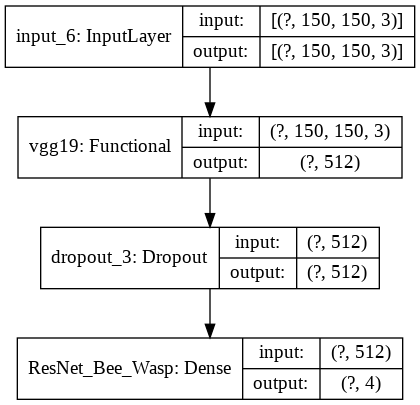

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vgg19_pretrained, show_shapes=True)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, restore_best_weights=True, verbose=1)

callbacks_list2=[reduce_lr,early_stopping]

In [ ]:
vgg19_pretrained.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
history2 = vgg19_pretrained.fit(train_vgg,
      steps_per_epoch=train_vgg.n//train_vgg.batch_size, #train / batch size. 
      epochs=30,
      validation_data=val_vgg,
      validation_steps=val_vgg.n//val_vgg.batch_size,
      callbacks=callbacks_list2)

Epoch 1/30
456/456 [==============================] - 45s 99ms/step - loss: 9.3630 - acc: 0.4453 - val_loss: 3.1538 - val_acc: 0.6570
Epoch 2/30
456/456 [==============================] - 46s 100ms/step - loss: 5.5711 - acc: 0.5875 - val_loss: 1.9739 - val_acc: 0.7553
Epoch 3/30
456/456 [==============================] - 46s 100ms/step - loss: 3.7384 - acc: 0.6768 - val_loss: 1.5665 - val_acc: 0.8079
Epoch 4/30
456/456 [==============================] - 45s 100ms/step - loss: 2.9317 - acc: 0.7187 - val_loss: 1.3974 - val_acc: 0.8298
Epoch 5/30
456/456 [==============================] - 45s 100ms/step - loss: 2.4711 - acc: 0.7508 - val_loss: 1.2628 - val_acc: 0.8491
Epoch 6/30
456/456 [==============================] - 45s 98ms/step - loss: 2.1496 - acc: 0.7688 - val_loss: 1.1590 - val_acc: 0.8544
Epoch 7/30
456/456 [==============================] - 45s 98ms/step - loss: 1.9356 - acc: 0.7865 - val_loss: 1.0857 - val_acc: 0.8640
Epoch 8/30
456/456 [==============================] - 45s 

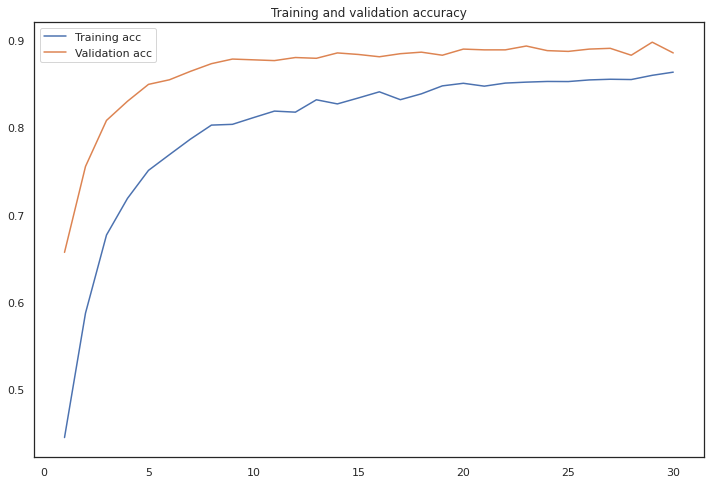

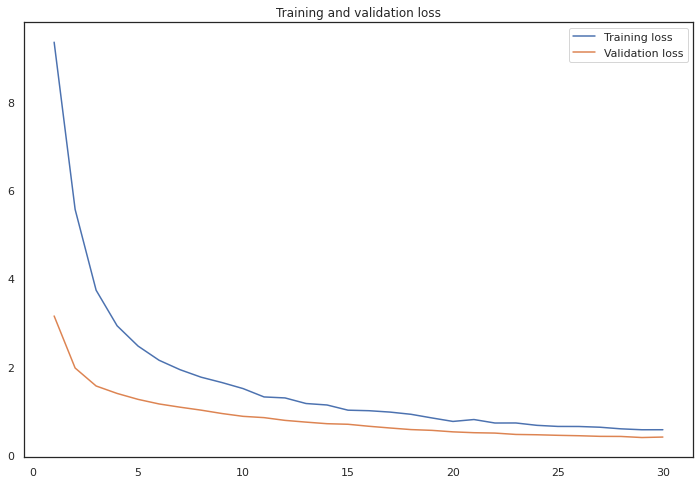

In [ ]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
vgg19_pretrained.evaluate(test_vgg)

58/58 [==============================] - 5s 89ms/step - loss: 0.4798 - acc: 0.8801


[0.4798133373260498, 0.8801400065422058]

##ResNet50 con imagenet

In [ ]:
#ResNet50
from keras import layers
from keras import models
from keras import utils
from keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from keras.applications import VGG19
from keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Add, Dense,Flatten
from tensorflow.keras.initializers import he_normal

In [ ]:
x_input = Input(shape=(224, 224, 3)) #definimos el input

In [ ]:
# Instanciamos la base convolucional de ResNet50 pre-entrenada en ImageNet
resnet50_pretrained = ResNet50(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=((224, 224, 3)),
)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet50_pretrained.layers:
    print(layer.name)

input_9
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [ ]:
# Freezamos los pesos de la base convolucional
resnet50_pretrained.trainable = False

In [ ]:
x = resnet50_pretrained(x_input)
x = Dropout(0.3)(x)
x = Dense(4, activation='softmax', name='ResNet_Bee_Wasp')(x)

# Instanciamos el modelo
resnet50_pretrained = Model(inputs=x_input, outputs=x, name='ResNet50')

In [ ]:
# Observamos el summary
resnet50_pretrained.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
ResNet_Bee_Wasp (Dense)      (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


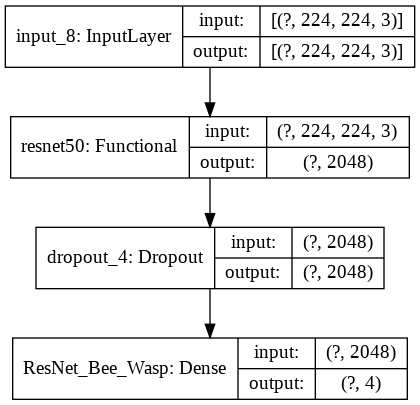

In [ ]:
plot_model(resnet50_pretrained, show_shapes=True)

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen_resnet = ImageDataGenerator(
    # Incluimos el preprocesamiento propio de ResNet50 en nuestro generador
    preprocessing_function=preprocess_input,
    horizontal_flip=True
)

val_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
#Creamos diferentes variables para generadores de train, valudacion test para cada modelo

train_generator50 = train_datagen_resnet.flow_from_dataframe(train,
            directory="kaggle_bee_vs_wasp/",
            x_col="path",
            y_col="label",
            has_ext=False,
            subset="training",
            batch_size=32,
            seed=42,
            clases=None,
            shuffle=True,
            class_mode="categorical",
            target_size=(224, 224),
            color_mode="rgb")

val_generator50 = val_datagen_resnet.flow_from_dataframe(val,
            directory="kaggle_bee_vs_wasp/",
            x_col="path",
            y_col="label",
            has_ext=False,
            batch_size=32,
            seed=42,
            classes=None,
            shuffle=False,
            class_mode="categorical",
            target_size=(224, 224),
            color_mode="rgb") 

test_datagen_resnet=ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator50 = test_datagen_resnet.flow_from_dataframe(test,
            directory="kaggle_bee_vs_wasp/",
            x_col="path",
            y_col='label',
            has_ext=False,
            target_size=(224, 224),
            class_mode="categorical",
            classes=None,
            batch_size=32,
            color_mode="rgb",
            seed=42,
            shuffle=False)

Found 9136 validated image filenames belonging to 4 classes.
Found 1142 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


In [ ]:
resnet50_pretrained.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['acc'])

In [ ]:
# Instanciamos early_stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True, verbose=1)

# Instanciamos chekpoint
checkpoint = ModelCheckpoint('pretrained/weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False, mode='auto')

es = [early_stopping]

In [ ]:
# Entrenamos la capa densa de nuestro modelo pre-entrenado
history_resnet = resnet50_pretrained.fit(train_generator50,
                                  steps_per_epoch=train_generator50.n//train_generator50.batch_size,
                                  epochs=30,
                                  validation_data=val_generator50,
                                  validation_steps=val_generator50.n//val_generator50.batch_size,
                                  callbacks=es)

Epoch 1/30
285/285 [==============================] - 51s 179ms/step - loss: 0.3335 - acc: 0.8824 - val_loss: 0.2021 - val_acc: 0.9286
Epoch 2/30
285/285 [==============================] - 51s 177ms/step - loss: 0.2064 - acc: 0.9276 - val_loss: 0.2089 - val_acc: 0.9286
Epoch 3/30
285/285 [==============================] - 50s 177ms/step - loss: 0.1859 - acc: 0.9366 - val_loss: 0.2058 - val_acc: 0.9304
Epoch 4/30
285/285 [==============================] - 51s 178ms/step - loss: 0.1682 - acc: 0.9405 - val_loss: 0.1917 - val_acc: 0.9304
Epoch 5/30
285/285 [==============================] - 50s 177ms/step - loss: 0.1582 - acc: 0.9424 - val_loss: 0.2068 - val_acc: 0.9304
Epoch 6/30
285/285 [==============================] - 49s 173ms/step - loss: 0.1579 - acc: 0.9440 - val_loss: 0.1978 - val_acc: 0.9348
Epoch 7/30
285/285 [==============================] - 49s 172ms/step - loss: 0.1488 - acc: 0.9486 - val_loss: 0.1909 - val_acc: 0.9366
Epoch 8/30
285/285 [==============================] - 4

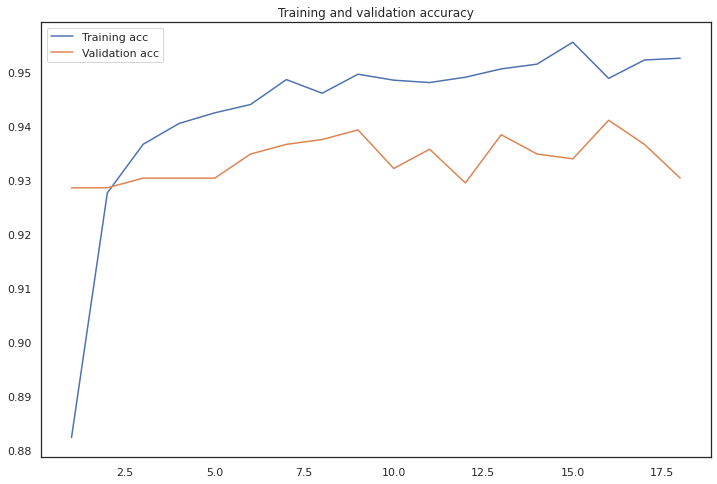

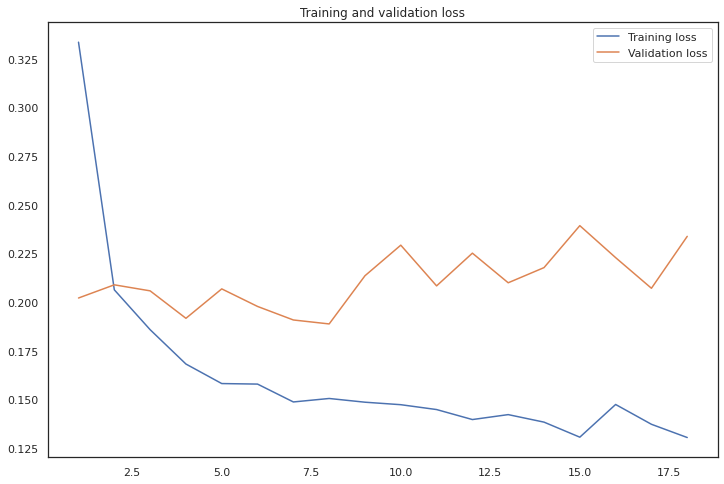

In [ ]:
acc_r= history_resnet.history['acc']
val_acc_r = history_resnet.history['val_acc']
loss_r = history_resnet.history['loss']
val_loss_r = history_resnet.history['val_loss']
epochs_r = range(1, len(acc_r) + 1)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(epochs_r, acc_r, label='Training acc')
plt.plot(epochs_r, val_acc_r, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs_r, loss_r, label='Training loss')
plt.plot(epochs_r, val_loss_r, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
resnet50_pretrained.evaluate(test_generator50)

36/36 [==============================] - 6s 154ms/step - loss: 0.2065 - acc: 0.9414


[0.2064657062292099, 0.9413823485374451]

In [ ]:
# Predecimos
val_pred_resnet = resnet50_pretrained.predict(val_generator50)

# Obtenemos la matriz de etiquetas reales de validación
val_labels_resnet = lb_classes.transform(val['label'])

# Evaluamos las shapes de los arrays
val_pred_resnet.shape, val_labels_resnet.shape

((1142, 4), (1142, 4))

In [ ]:
#generar best_threshold
threshold = np.arange(0.1, 0.9, 0.05)

# Definimos listas vacíos donde volcamos los resultados
acc_ = []
accs = []
best_threshold = np.zeros(val_pred_resnet.shape[1])

# Iteramos sobre las distintas clases
for i in range(len(best_threshold)):
    # Indexamos las probabilidades predichas por clase
    y_prob = np.array(val_pred_resnet[:, i])
    
    # Iteramos sobre los posibles umbrales
    for j in threshold:
        # Binarizamos las predicciones de acuerdo al umbral
        y_pred = [1 if prob >= j else 0 for prob in y_prob]
        y_pred = np.array(y_pred)
        # Calculamos accuracy
        acc = accuracy_score(val_labels_resnet[:, i], y_pred)
        acc_.append(acc)
    
    # Volcamos los resultados en las listas generales
    acc_  = np.array(acc_)
    index = np.where(acc_==acc_.max())
    accs.append(acc_.max())
    best_threshold[i] = threshold[index[0][0]]
    # Vaciamos la lista de para volver a iterar
    acc_ = []

In [ ]:
accs

[0.9649737302977233, 0.968476357267951, 0.9982486865148862, 0.9448336252189142]

In [ ]:
best_threshold

array([0.15, 0.5 , 0.1 , 0.7 ])

In [ ]:
y_pred_resnet = np.array([[1 if val_pred_resnet[i, j] >= best_threshold[j] else 0 for j in range(val_labels_resnet.shape[1])] for i in range(len(val_labels_resnet))])

bee
Accuracy: 0.96 Precision: 0.94 Recall: 0.93 F1: 0.93
insect
Accuracy: 0.97 Precision: 0.94 Recall: 0.91 F1: 0.92
other
Accuracy: 1.0 Precision: 1.0 Recall: 0.96 F1: 0.98
wasp
Accuracy: 0.94 Precision: 0.93 Recall: 0.94 F1: 0.93


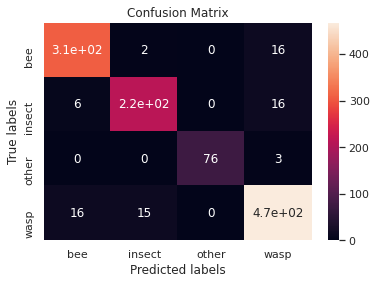

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Definimos listas vacías para ir volcando las métricas por clase
accuracy_per_class = []
precision_per_class = []
recall_per_class = []
f1_per_class = []

# Definimos un listado de etiquetas de clase
classes = list(lb_classes.classes_)

for i in range(val_labels_resnet.shape[1]):
    # Computamos las métricas de evaluación por clase y hacemos un append a la lista correspondiente
    accuracy_per_class.append(accuracy_score(val_labels_resnet[:, i], (val_pred_resnet[:, i] > 0.5).astype(int)).round(2))
    precision_per_class.append(precision_score(val_labels_resnet[:,  i], (val_pred_resnet[:, i] > 0.5).astype(int)).round(2))
    recall_per_class.append(recall_score(val_labels_resnet[:,  i], (val_pred_resnet[:, i] > 0.5).astype(int)).round(2))
    f1_per_class.append(f1_score(val_labels_resnet[:,  i], (val_pred_resnet[:, i] > 0.5).astype(int)).round(2))
    
    print(classes[i])
    print('Accuracy:', accuracy_per_class[i], 'Precision:', precision_per_class[i],
          'Recall:', recall_per_class[i], 'F1:', f1_per_class[i])
from sklearn.metrics import confusion_matrix
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(val_pred_resnet,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(val_labels_resnet,axis = 1) 
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes) 
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
  #matrices de confusión de cada clase sobre el set de validación
  #Lo que mejor clasifica el modelo son otros objetos que nos son insectos
  #de la clase insectos clasifica más falsos negativos que falsos positivos

bee
Accuracy: 0.96 Precision: 0.94 Recall: 0.93 F1: 0.93


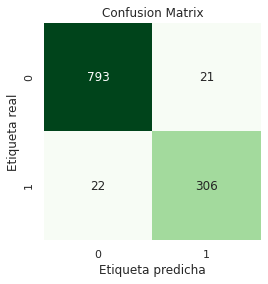

insect
Accuracy: 0.97 Precision: 0.94 Recall: 0.91 F1: 0.92


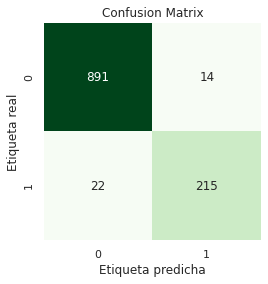

other
Accuracy: 1.0 Precision: 1.0 Recall: 0.96 F1: 0.98


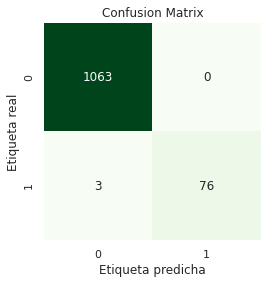

wasp
Accuracy: 0.94 Precision: 0.93 Recall: 0.94 F1: 0.93


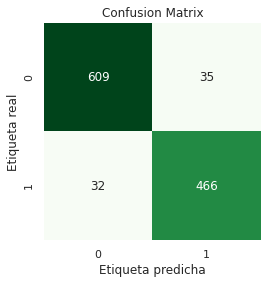

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Definimos listas vacías para ir volcando las métricas por clase
accuracy_per_class = []
precision_per_class = []
recall_per_class = []
f1_per_class = []

# Definimos un listado de etiquetas de clase
classes = list(lb_classes.classes_)

for i in range(val_labels_resnet.shape[1]):
    # Computamos las métricas de evaluación por clase y hacemos un append a la lista correspondiente
    accuracy_per_class.append(accuracy_score(val_labels_resnet[:, i], (val_pred_resnet[:, i] > 0.5).astype(int)).round(2))
    precision_per_class.append(precision_score(val_labels_resnet[:,  i], (val_pred_resnet[:, i] > 0.5).astype(int)).round(2))
    recall_per_class.append(recall_score(val_labels_resnet[:,  i], (val_pred_resnet[:, i] > 0.5).astype(int)).round(2))
    f1_per_class.append(f1_score(val_labels_resnet[:,  i], (val_pred_resnet[:, i] > 0.5).astype(int)).round(2))
    
    print(classes[i])
    print('Accuracy:', accuracy_per_class[i], 'Precision:', precision_per_class[i],
          'Recall:', recall_per_class[i], 'F1:', f1_per_class[i])
    
    # Visualizamos la matriz de confusión por clase
    cm  = confusion_matrix(val_labels_resnet[:,  i], (val_pred_resnet[:, i] > 0.5).astype(int))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='.0f', cbar=False, square=True,)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.title('Confusion Matrix')
    plt.show()

  #matrices de confusión de cada clase sobre el set de validación
  #Lo que mejor clasifica el modelo son otros objetos que nos son insectos
  #de la clase insectos clasifica más falsos negativos que falsos positivos

In [ ]:
# Predecimos

test_pred_resnet = resnet50_pretrained.predict(test_generator50)

# Tomamos los umbrales óptimos obtenidos en validación para mapear probabilidades a etiquetas de clase
y_pred_resnet = np.array([[1 if test_pred_resnet[i, j] >= best_threshold[j] else 0 for j in range(test_pred_resnet.shape[1])] for i in range(len(test_pred_resnet))])

# Creamos un DF de y_pred
y_pred_resnet = pd.DataFrame(y_pred_resnet, index=test.index)

# Evaluamos las shapes de los arrays resultantes
y_pred_resnet.shape


(1143, 4)

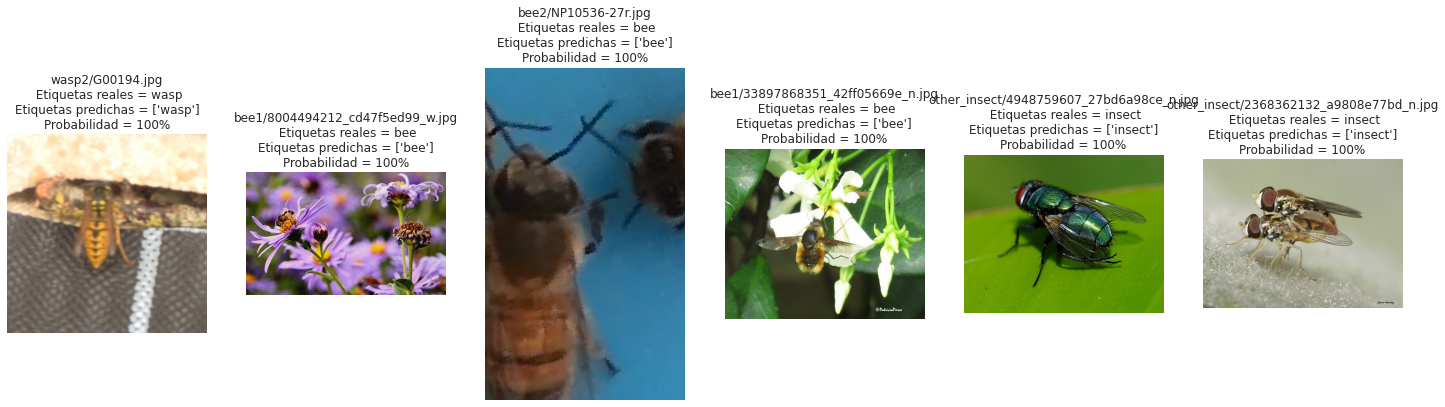

In [ ]:
import time
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import load_img, img_to_array
data_dir= "/content/kaggle_bee_vs_wasp"

bichos = list()
n = 6
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_bichos = np.random.choice(test['path'])
    while random_bichos in bichos:
        random_bichos = np.random.choice(test['path'])
    bichos.append(random_bichos)

    # Imagen original
    random_bichos_path = os.path.join(data_dir, random_bichos)
    test_image = load_img(random_bichos_path, target_size=(224, 224))
    test_image = img_to_array(test_image)
 
    # Predicción
    prediction = y_pred_resnet.loc[test.loc[test['path'] == random_bichos].index[0]]
    prediction_probability=np.amax(prediction)
    predicted_labels = (prediction > 0.50).astype(int)
    # Etiquetas
    labels = lb_classes.classes_[predicted_labels > 0]

    # Visualizamos la imagen y su predicción
    title = "{}\n Etiquetas reales = {}\nEtiquetas predichas = {}\nProbabilidad = {}%" \
                .format(test.loc[test['path'] == random_bichos, 'path'].values[0],
                        test.loc[test['path'] == random_bichos, 'label'].values[0],
                        labels, prediction_probability*100 if prediction_probability>0.5 else (1-prediction_probability)*100)

    axes[i].imshow(plt.imread(os.path.join(data_dir, random_bichos)))
    axes[i].set_title(title)
    axes[i].axis('off')


In [ ]:
#creamos variables para almacenar test y train acc de cada modelo
train_model3=model3.evaluate(train_generator)
test_model3=model3.evaluate(test_g)

result_train_vgg=vgg19_pretrained.evaluate(train_vgg)
result_test_vgg=vgg19_pretrained.evaluate(test_vgg)

train_resnet=resnet50_pretrained.evaluate(train_generator50)
test_resnet=resnet50_pretrained.evaluate(test_generator50)

36/36 [==============================] - 5s 145ms/step - loss: 0.2065 - acc: 0.9414


In [ ]:
#Creamos un DataFrame para mostrar los scores de cada modelo
df_Results=pd.DataFrame(columns=['Model','Train Loss & Acc','Test Loss & Acc'])

df_Results.loc[1,'Model']='Modelo 1'
df_Results.loc[1,'Train Loss & Acc']=train_model3
df_Results.loc[1,'Test Loss & Acc']=test_model3

df_Results.loc[2,'Model']='VGG19'
df_Results.loc[2,'Train Loss & Acc']=result_train_vgg
df_Results.loc[2,'Test Loss & Acc']=result_test_vgg

df_Results.loc[3,'Model']='Resnet 50'
df_Results.loc[3,'Train Loss & Acc']=train_resnet
df_Results.loc[3,'Test Loss & Acc']=test_resnet

df_Results

,Model,Train Loss & Acc,Test Loss & Acc
1,Modelo 1,"[0.810147225856781, 0.7131129503250122]","[0.8747650384902954, 0.6981627345085144]"
2,VGG19,"[0.32709577679634094, 0.9075087308883667]","[0.4798133373260498, 0.8801400065422058]"
3,Resnet 50,"[0.09847599267959595, 0.9651926159858704]","[0.2064657062292099, 0.9413823485374451]"
